In [46]:
print("HELLOW WORLD!")

HELLOW WORLD!


In [47]:
import sqlite3
import pandas as pd

In [48]:
conn = sqlite3.connect('sqlite-sakila.db')

query_table = "SELECT name from sqlite_master WHERE Type='table';"
table_names = pd.read_sql_query(query_table,conn)['name'].tolist()

print(f'Tables in database :\n {table_names}')

Tables in database :
 ['actor', 'country', 'city', 'address', 'language', 'category', 'customer', 'film', 'film_actor', 'film_category', 'film_text', 'inventory', 'staff', 'store', 'payment', 'rental']


In [49]:
dfs = {}

for table in table_names:
    dfs[table] = pd.read_sql_query(f'Select * from {table}',conn)
    print(f'Read table {table}')

conn.close()

Read table actor
Read table country
Read table city
Read table address
Read table language
Read table category
Read table customer
Read table film
Read table film_actor
Read table film_category
Read table film_text
Read table inventory
Read table staff
Read table store
Read table payment
Read table rental


In [50]:
df_rental = dfs['rental']
df_customer = dfs['customer']
df_payment = dfs['payment']
df_store = dfs['store']
df_film = dfs['film']
df_inventory = dfs['inventory']
df_category = dfs['category']
df_category_film = dfs['film_category']

In [51]:
df_rental.head()

,rental_id,rental_date,inventory_id,customer_id,return_date,staff_id,last_update
0,1,2005-05-24 22:53:30.000,367,130,2005-05-26 22:04:30.000,1,2021-03-06 15:53:41
1,2,2005-05-24 22:54:33.000,1525,459,2005-05-28 19:40:33.000,1,2021-03-06 15:53:41
2,3,2005-05-24 23:03:39.000,1711,408,2005-06-01 22:12:39.000,1,2021-03-06 15:53:41
3,4,2005-05-24 23:04:41.000,2452,333,2005-06-03 01:43:41.000,2,2021-03-06 15:53:41
4,5,2005-05-24 23:05:21.000,2079,222,2005-06-02 04:33:21.000,1,2021-03-06 15:53:41


In [52]:
# Query : find the rentals per month

df_rental['rental_only_date'] = pd.to_datetime(df_rental['rental_date'])

result = (
    df_rental
    .assign(month=df_rental['rental_only_date'].dt.strftime('%Y-%m'))
    .groupby('month',as_index=False)
    .size()
    .rename(columns={'size':'rentals'})
    .sort_values('month')
)

print(result)

     month  rentals
0  2005-05     1156
1  2005-06     2311
2  2005-07     6709
3  2005-08     5686
4  2006-02      182


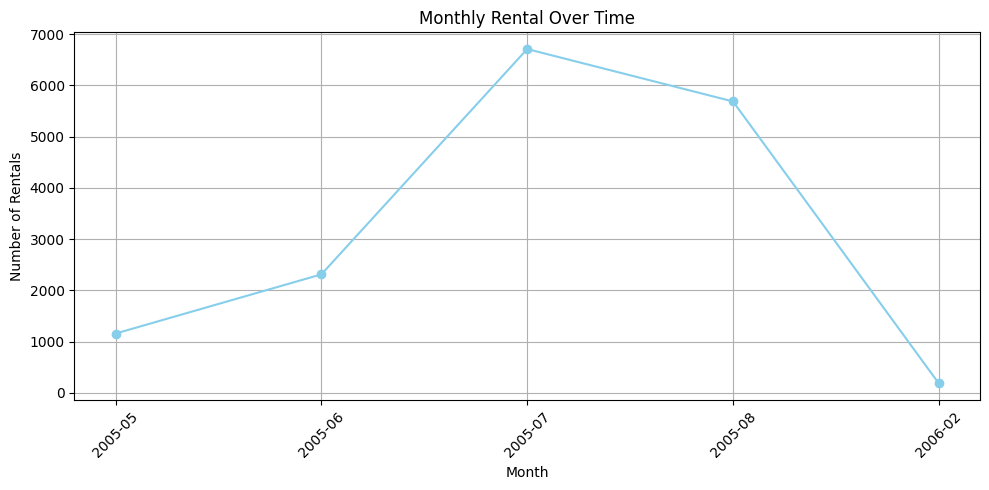

In [53]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(result['month'],result['rentals'],marker='o',color='skyblue')
plt.title('Monthly Rental Over Time')
plt.xlabel('Month')
plt.ylabel('Number of Rentals')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()


In [54]:
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rental_id         16044 non-null  int64         
 1   rental_date       16044 non-null  object        
 2   inventory_id      16044 non-null  int64         
 3   customer_id       16044 non-null  int64         
 4   return_date       15861 non-null  object        
 5   staff_id          16044 non-null  int64         
 6   last_update       16044 non-null  object        
 7   rental_only_date  16044 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(4), object(3)
memory usage: 1002.9+ KB


In [55]:
df_film.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   film_id               1000 non-null   int64  
 1   title                 1000 non-null   object 
 2   description           1000 non-null   object 
 3   release_year          1000 non-null   object 
 4   language_id           1000 non-null   int64  
 5   original_language_id  0 non-null      object 
 6   rental_duration       1000 non-null   int64  
 7   rental_rate           1000 non-null   float64
 8   length                1000 non-null   int64  
 9   replacement_cost      1000 non-null   float64
 10  rating                1000 non-null   object 
 11  special_features      1000 non-null   object 
 12  last_update           1000 non-null   object 
dtypes: float64(2), int64(4), object(7)
memory usage: 101.7+ KB


In [56]:
# find the top 10 films with the most rental

merged = df_rental.merge(df_inventory, on='inventory_id',how='inner')
merged = merged.merge(df_film,on='film_id',how='inner')

top_10_films = (
    merged.groupby(['film_id','title'], as_index=False)
    .size()
    .rename(columns={'size':'rentals'})
    .sort_values('rentals',ascending=False)
    .head(10)

)

In [57]:
top_10_films

,film_id,title,rentals
96,103,BUCKET BROTHERHOOD,34
705,738,ROCKETEER MOTHER,33
312,331,FORWARD TEMPLE,32
361,382,GRIT CLOCKWORK,32
697,730,RIDGEMONT SUBMARINE,32
465,489,JUGGLER HARDLY,32
733,767,SCALAWAG DUCK,32
957,1000,ZORRO ARK,31
594,621,NETWORK PEAK,31
348,369,GOODFELLAS SALUTE,31


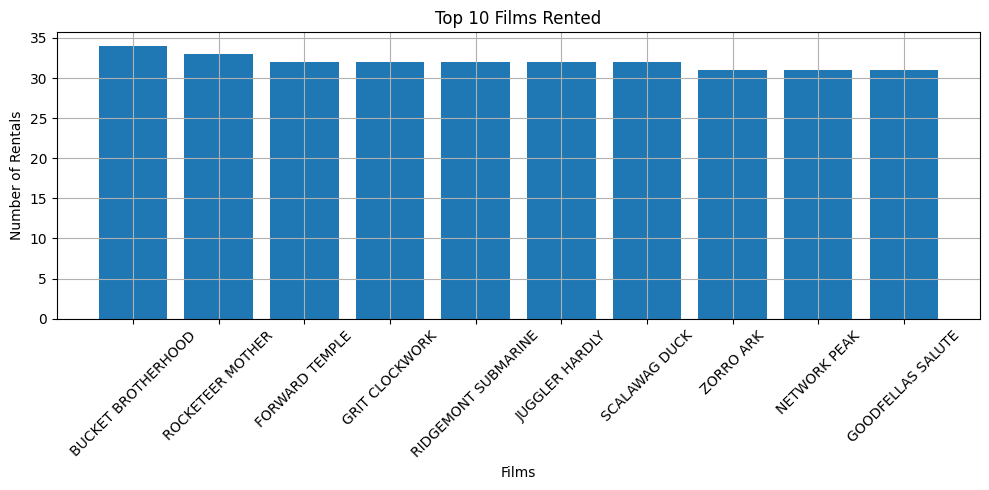

In [58]:
plt.figure(figsize=(10,5))
plt.bar(top_10_films['title'],top_10_films['rentals'])
plt.title('Top 10 Films Rented')
plt.xlabel('Films')
plt.ylabel('Number of Rentals')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

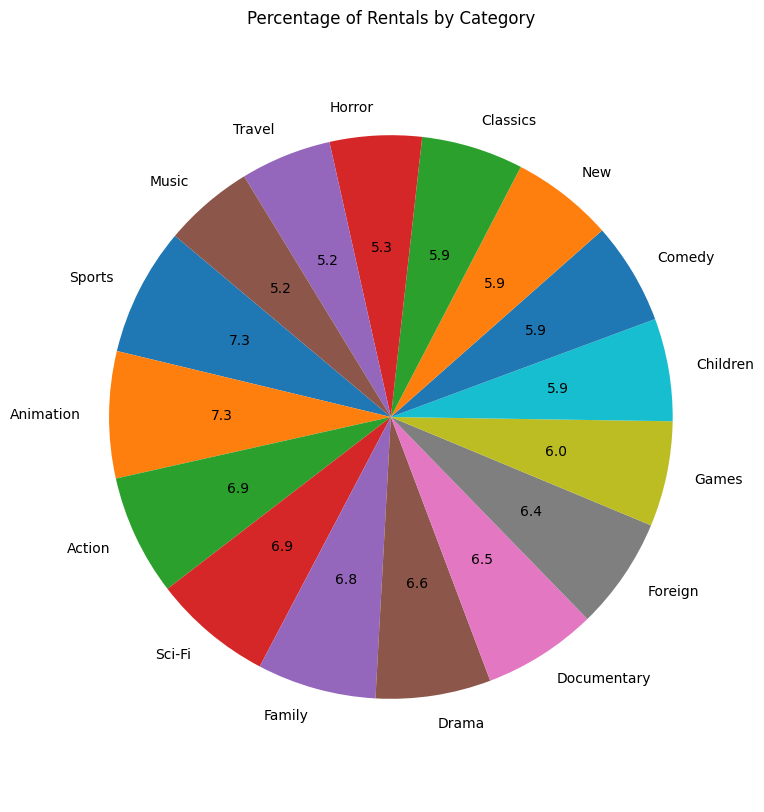

In [59]:
category_rentals = (
    df_rental
    .merge(df_inventory.drop(columns=["last_update"]),on='inventory_id',how='inner')
    .merge(df_category_film.drop(columns=["last_update"]),on='film_id',how='inner')
    .merge(df_category.drop(columns=["last_update"]),on='category_id',how='inner')
    .groupby("name",as_index=False)
    .size()
    .rename(columns={"name":"category","size":"rentals"})
    .sort_values("rentals",ascending=False)
)

plt.figure(figsize=(8,10))
plt.pie(
    category_rentals["rentals"],
    labels=category_rentals["category"],
    autopct="%1.1f",
    startangle=140
)

plt.title("Percentage of Rentals by Category")
plt.axis("equal")
plt.show()

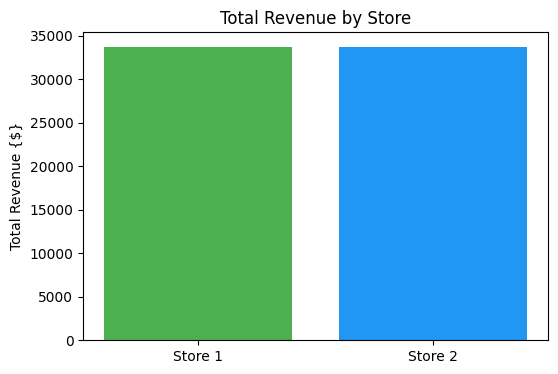

In [60]:
revenue_by_store = (
    df_payment
    .merge(df_rental[['rental_id','inventory_id']],on='rental_id',how='inner')
    .merge(df_inventory[['inventory_id','store_id']],on='inventory_id',how='inner')
    .merge(df_store[['store_id']],on='store_id',how='inner')
    .groupby('store_id',as_index=False)['amount']
    .sum()
    .rename(columns={'amount':'total_revenue'})
    .sort_values('store_id')
    
)

plt.figure(figsize=(6,4))
plt.bar(revenue_by_store['store_id'],revenue_by_store['total_revenue'],color=['#4CAF50','#2196F3'])
plt.xticks(revenue_by_store['store_id'],[f"Store {sid}" for sid in revenue_by_store['store_id']])
plt.ylabel("Total Revenue {$}")
plt.title("Total Revenue by Store")
plt.show()

In [61]:
revenue_by_store

,store_id,total_revenue
0,1,33679.79
1,2,33726.77


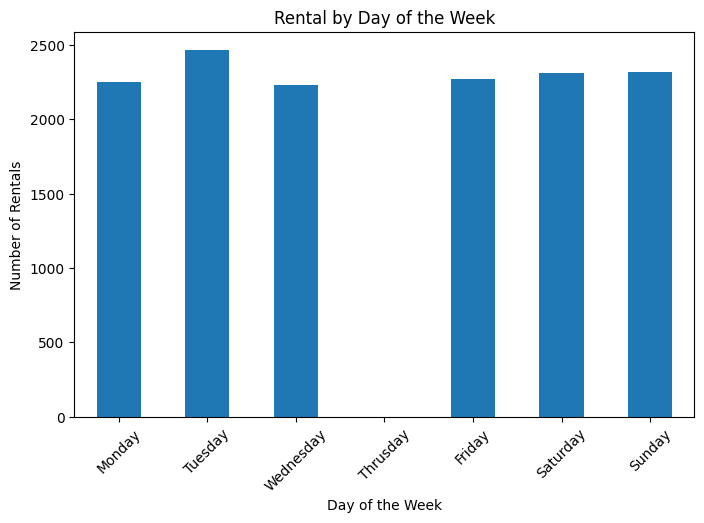

In [62]:
df_rental['day_of_week'] = df_rental['rental_only_date'].dt.day_name()

rental_by_day = (
    df_rental
    .groupby('day_of_week')
    .size()
)

day_order=['Monday','Tuesday','Wednesday','Thrusday','Friday','Saturday','Sunday']
rental_by_day = rental_by_day.reindex(day_order)

# Plot
rental_by_day.plot(kind='bar', figsize=(8,5))
plt.title('Rental by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Number of Rentals')
plt.xticks(rotation=45)
plt.show()

In [63]:
top_customers = (
    df_rental
    .groupby("customer_id") 
    .size()
    .reset_index(name="rental_count")
    .merge(df_customer, on="customer_id", how="left")
    .sort_values("rental_count",ascending=False)
)
   

In [64]:
top_five = top_customers.head(5)

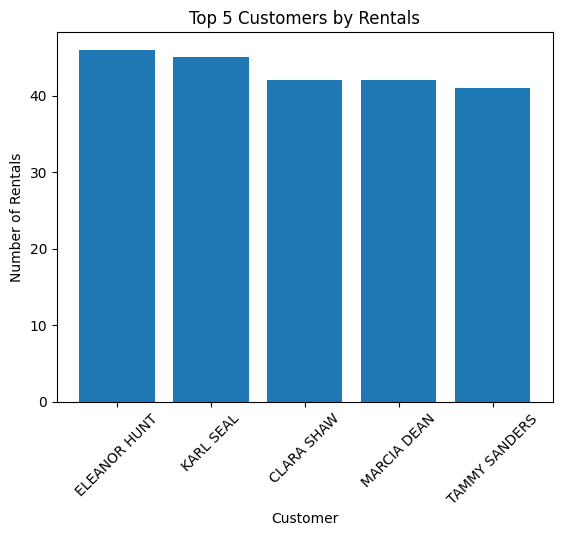

In [65]:
plt.bar(top_five["first_name"] + " " + top_five["last_name"], top_five["rental_count"])
plt.title("Top 5 Customers by Rentals")
plt.xlabel("Customer")
plt.ylabel("Number of Rentals")
plt.xticks(rotation=45)
plt.show()

In [66]:
# Average Rental Duration 
df_rental.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16044 entries, 0 to 16043
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   rental_id         16044 non-null  int64         
 1   rental_date       16044 non-null  object        
 2   inventory_id      16044 non-null  int64         
 3   customer_id       16044 non-null  int64         
 4   return_date       15861 non-null  object        
 5   staff_id          16044 non-null  int64         
 6   last_update       16044 non-null  object        
 7   rental_only_date  16044 non-null  datetime64[ns]
 8   day_of_week       16044 non-null  object        
dtypes: datetime64[ns](1), int64(4), object(4)
memory usage: 1.1+ MB


In [67]:
merged_df = (
    df_rental
    .merge(df_inventory.drop(columns=["last_update"]), on="inventory_id")
    .merge(df_film.drop(columns=["last_update"]), on="film_id")
    .merge(df_category_film.drop(columns=["last_update"]), on="film_id")
    .merge(df_category.drop(columns=["last_update"]), on="category_id")
)

In [68]:
merged_df['rental_date'] = pd.to_datetime(merged_df['rental_date'])
merged_df['return_date'] = pd.to_datetime(merged_df['return_date'])

merged_df['rental_duration_days'] = (merged_df['return_date'] - merged_df['rental_date'])

avg_rental_dur = (
    merged_df.groupby('name')['rental_duration_days']
    .mean()
    .reset_index()
    .sort_values("rental_duration_days",ascending=False)
)

In [69]:
avg_rental_dur

,name,rental_duration_days
14,Sports,5 days 04:43:48.917525773
9,Games,5 days 04:24:44.167539267
4,Comedy,5 days 03:34:51.695278969
13,Sci-Fi,5 days 01:54:12.735590118
11,Music,5 days 01:39:51.282051282
5,Documentary,5 days 01:22:12.483221476
7,Family,5 days 01:13:53.905817174
10,Horror,5 days 00:55:33.884892086
0,Action,5 days 00:38:36.821917808
12,New,5 days 00:35:17.540453074


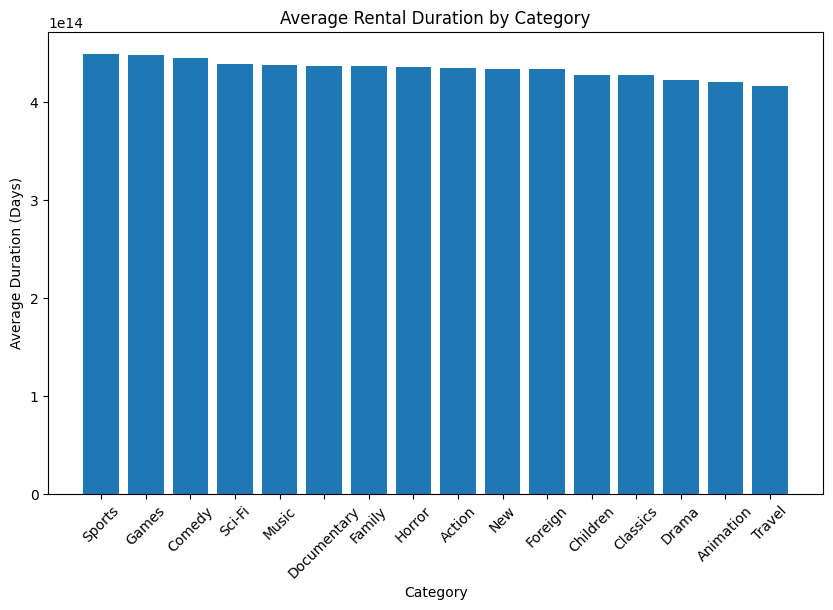

In [70]:
plt.figure(figsize=(10,6))
plt.bar(avg_rental_dur["name"], avg_rental_dur["rental_duration_days"])
plt.title("Average Rental Duration by Category")
plt.xlabel("Category")
plt.ylabel("Average Duration (Days)")
plt.xticks(rotation=45)
plt.show()